In [1]:
from datetime import datetime, date

import ibis
import numpy as np
import pandas as pd
# local
from settings import conf
from utils import cursor2df
from gen_data import salary_date, salary_date_schema

### Data

In [2]:
df_salary1 = salary_date()
print(df_salary1.dtypes)
df_salary1

last_name                     object
salary                       float64
date_of_birth                 object
timestamp_of_birth    datetime64[ns]
dtype: object


,last_name,salary,date_of_birth,timestamp_of_birth
0,Name 2010 1 1,2010011.0,2010-01-01,2010-01-01 01:01:01.001001001
1,Name 2011 1 1,2011011.0,2011-01-01,2011-01-01 01:01:01.001001001
2,Name 2012 1 1,2012011.0,2012-01-01,2012-01-01 01:01:01.001001001
3,Name 2013 1 1,2013011.0,2013-01-01,2013-01-01 01:01:01.001001001
4,Name 2014 1 1,2014011.0,2014-01-01,2014-01-01 01:01:01.001001001
...,...,...,...,...
4013,Name 2016 12 31,2016151.0,2016-12-31,2016-12-31 12:12:12.012012031
4014,Name 2017 12 31,2017151.0,2017-12-31,2017-12-31 12:12:12.012012031
4015,Name 2018 12 31,2018151.0,2018-12-31,2018-12-31 12:12:12.012012031
4016,Name 2019 12 31,2019151.0,2019-12-31,2019-12-31 12:12:12.012012031


In [3]:
df_salary1.to_csv('./salary_example.csv')

In [4]:
sch = salary_date_schema()
sch

ibis.Schema {  
  last_name           string
  salary              float64
  date_of_birth       date
  timestamp_of_birth  timestamp
}

In [5]:
con = {}
table_name = 'salary'

In [6]:
def test_woy(result, expected):
    pd.testing.assert_series_equal(result, expected, check_dtype=False, check_names=False)

### OmniSciDB

In [7]:
con['omniscidb'] = ibis.omniscidb.connect(**conf['omniscidb'])

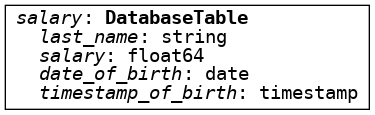

In [8]:
con['omniscidb'].drop_table(table_name, force=True)
con['omniscidb'].create_table(table_name, schema=sch)
con['omniscidb'].load_data(table_name, df_salary1)
t = con['omniscidb'].table(table_name)
t

In [9]:
df = t.execute()

In [10]:
sql = '''
SELECT
  EXTRACT(WEEK FROM "timestamp_of_birth") AS tmp
FROM salary
'''

result = cursor2df(con['omniscidb'].con.execute(sql)).tmp

test_woy(result, df.timestamp_of_birth.dt.weekofyear.astype('int16'))

AssertionError: Series are different

Series values are different (37.90443 %)
[left]:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 5, 5, 5, 6, 6, 5, 5, 5, 5, 10, 10, 9, 9, 9, 10, 10, 9, 9, 9, 10, 14, 14, 14, 14, 14, 14, 14, 13, 14, 14, 14, 18, 19, 18, 18, 18, 18, 19, 18, 18, 18, 18, 23, 23, 22, 22, 23, 23, 23, 22, 22, 22, 23, 27, 27, 27, 27, 27, 27, 27, 26, 27, 27, 27, 32, 32, 31, 31, 31, 31, 32, 31, 31, 31, 31, 36, 36, 35, 36, 36, 36, 36, 35, 35, 36, 36, 40, ...]
[right]: [53, 52, 52, 1, 1, 1, 53, 52, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 13, 13, 13, 14, 14, 14, 13, 13, 13, 14, 14, 17, 17, 18, 18, 18, 18, 17, 18, 18, 18, 18, 22, 22, 22, 22, 22, 23, 22, 22, 22, 22, 23, 26, 26, 26, 27, 27, 27, 26, 26, 26, 27, 27, 30, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 35, 35, 35, 35, 36, 36, 35, 35, 35, 35, 36, 39, ...]

In [11]:
sql = '''
SELECT
  CASE
    WHEN CAST(floor(((EXTRACT(DOY FROM "timestamp_of_birth") - (EXTRACT(ISODOW FROM "timestamp_of_birth")- 1 + 1)) + 10) / 7) AS SMALLINT) < 1 THEN CASE WHEN ((mod((((EXTRACT(YEAR FROM "timestamp_of_birth") - 1) + floor((EXTRACT(YEAR FROM "timestamp_of_birth") - 1) / 4)) - floor((EXTRACT(YEAR FROM "timestamp_of_birth") - 1) / 100)) + floor((EXTRACT(YEAR FROM "timestamp_of_birth") - 1) / 400), 7)) = 4) OR ((mod(((((EXTRACT(YEAR FROM "timestamp_of_birth") - 1) - 1) + floor(((EXTRACT(YEAR FROM "timestamp_of_birth") - 1) - 1) / 4)) - floor(((EXTRACT(YEAR FROM "timestamp_of_birth") - 1) - 1) / 100)) + floor(((EXTRACT(YEAR FROM "timestamp_of_birth") - 1) - 1) / 400), 7)) = 3) THEN 1 ELSE 0 END + 52
    WHEN CAST(floor(((EXTRACT(DOY FROM "timestamp_of_birth") - (EXTRACT(ISODOW FROM "timestamp_of_birth")- 1 + 1)) + 10) / 7) AS SMALLINT) > (CASE WHEN ((mod(((EXTRACT(YEAR FROM "timestamp_of_birth") + floor(EXTRACT(YEAR FROM "timestamp_of_birth") / 4)) - floor(EXTRACT(YEAR FROM "timestamp_of_birth") / 100)) + floor(EXTRACT(YEAR FROM "timestamp_of_birth") / 400), 7)) = 4) OR ((mod((((EXTRACT(YEAR FROM "timestamp_of_birth") - 1) + floor((EXTRACT(YEAR FROM "timestamp_of_birth") - 1) / 4)) - floor((EXTRACT(YEAR FROM "timestamp_of_birth") - 1) / 100)) + floor((EXTRACT(YEAR FROM "timestamp_of_birth") - 1) / 400), 7)) = 3) THEN 1 ELSE 0 END + 52) THEN 1
    ELSE CAST(floor(((EXTRACT(DOY FROM "timestamp_of_birth") - (EXTRACT(ISODOW FROM "timestamp_of_birth")- 1 + 1)) + 10) / 7) AS SMALLINT)
  END AS tmp
FROM salary
'''

result = cursor2df(con['omniscidb'].con.execute(sql)).tmp
test_woy(result, df.timestamp_of_birth.dt.weekofyear.astype('int16'))

## PostgreSQL

In [12]:
db = 'postgres'
con[db] = ibis.postgres.connect(**conf[db])

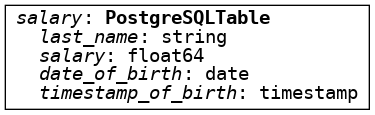

In [13]:
con[db].drop_table(table_name, force=True)
con[db].create_table(table_name, schema=sch)
con[db].load_data(table_name, df_salary1, if_exists='append')
t = con[db].table(table_name)
t

In [14]:
expr = t.timestamp_of_birth.week_of_year().name('tmp')
expr = t[expr]

print(str(expr.compile()))

result = expr.execute().tmp
test_woy(result, df.timestamp_of_birth.dt.weekofyear.astype('int16'))

SELECT CAST(EXTRACT(week FROM t0.timestamp_of_birth) AS SMALLINT) AS tmp 
FROM salary AS t0
